In [1]:
import os
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle
    import pathlib

with open('/home/joon/xai/causal/stable-baselines3/outputs/custom_range_save_more/data.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [2]:
ranges = data["ranges"]
counts = data["counts"]

[19, 19, 36, 13]
State and binned state value:
None
[-0.17999999999999994, -0.12857142857142856, 0.08975, -0.15675]


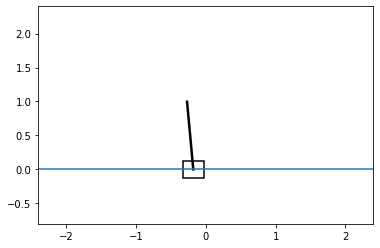

[0.09668843 0.12201695 0.02146504 0.01132356]


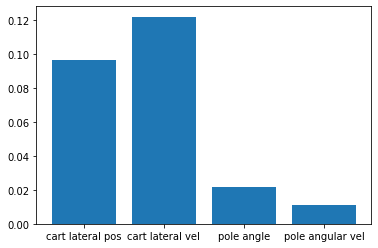

[0.09434422 0.09395308 0.03697982 0.04519072]


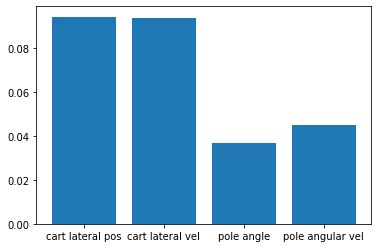

[0.09551632 0.10798491 0.02922248 0.02825725]


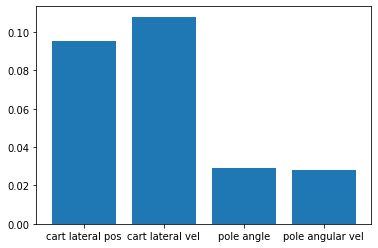

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   8.   8.  24.  32.
  93. 147. 244. 256. 344. 305. 250. 160.  91.  46.  23.   3.   2.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
pbc -- 
2039.0 12910.0 14949.0
19


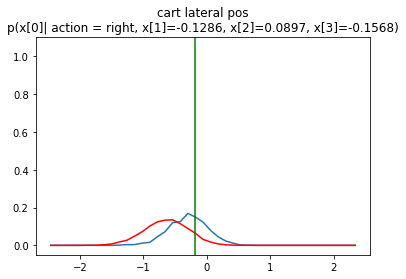

point biserial coefficient = 0.32354373414605914
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.  17. 103. 305. 509. 524. 404. 180.  47.   8.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
pbc -- 
2097.0 3264.0 5361.0
19


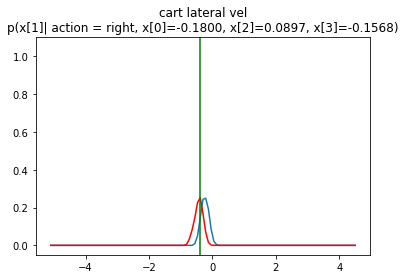

point biserial coefficient = 0.5876869951630397
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   1.   1.   0.   1.   5.  10.  12.  22.  21.
  24.  23.  43.  36.  47.  50.  49. 434. 305.  98.   6.   0.   0.]
pbc -- 
1188.0 26156.0 27344.0
36


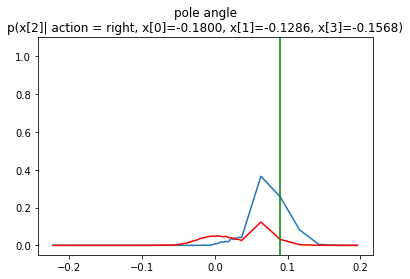

point biserial coefficient = 0.3030289812233931
[  0.   0.   0.   0.   0.   0.   0.   4.   5.  30.  67.  91. 193. 305.
 457. 572. 635. 742. 803. 771. 778. 621. 472. 320. 181.  65.  19.   2.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
pbc -- 
7133.0 10759.0 17892.0
13


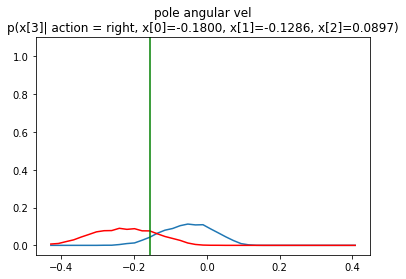

point biserial coefficient = 0.7307854604210479


In [3]:
import numpy as np

def get_index(div_ranges, obs):
    result = []
    for i, _range in enumerate(div_ranges):
        idx = -1
        for j, x in enumerate(_range):
            if obs[i] <= x:
                idx = j
                break
        if idx == -1:
            result.append(len(_range) - 1)
        else:
            result.append(idx)
    return result

def exp_gen(ranges, counts, state=None):
    
    avg = []
    stderr = []

    dp = []
    if state is None:
        pd = np.sum(np.sum(counts, axis=0), axis=0).flatten()
        pd = pd / np.sum(pd)
        pick = int(np.nonzero(np.random.multinomial(1, pd))[0])

        dp = []
        for i in range(4):
            dp = [pick % len(ranges[i])] + dp
            pick = pick // len(ranges[i])
        #dp = [10, 9, 10, 11]
    else:
        dp = get_index(ranges, state)       
        

    print(dp)
    real_dp = []
    probs = []
    errs = []
    to_probs = []
    to_errs = []

    for i in range(4):
        real_dp += [(ranges[i][dp[i]-1] + ranges[i][dp[i]])/2]

    print("State and binned state value:")
    print(state)
    print(real_dp)

    for action in range(2):
        probs += [np.average(np.sum(counts[:, action, dp[0], :, :, :], axis=(1,2,3)) / np.sum(counts[:, action, :, :, :, :], axis=(1,2,3,4)))]
        errs += [np.std(np.sum(counts[:, action, dp[0], :, :, :], axis=(1,2,3)) / np.sum(counts[:, action, :, :, :, :], axis=(1,2,3,4)))]
        probs += [np.average(np.sum(counts[:, action, :, dp[1], :, :], axis=(1,2,3)) / np.sum(counts[:, action, :, :, :, :], axis=(1,2,3,4)))]
        errs += [np.std(np.sum(counts[:, action, :, dp[1], :, :], axis=(1,2,3)) / np.sum(counts[:, action, :, :, :, :], axis=(1,2,3,4)))]
        probs += [np.average(np.sum(counts[:, action, :, :, dp[2], :], axis=(1,2,3)) / np.sum(counts[:, action, :, :, :, :], axis=(1,2,3,4)))]
        errs += [np.std(np.sum(counts[:, action, :, :, dp[2], :], axis=(1,2,3)) / np.sum(counts[:, action, :, :, :, :], axis=(1,2,3,4)))]
        probs += [np.average(np.sum(counts[:, action, :, :, :, dp[3]], axis=(1,2,3)) / np.sum(counts[:, action, :, :, :, :], axis=(1,2,3,4)))]
        errs += [np.std(np.sum(counts[:, action, :, :, :, dp[3]], axis=(1,2,3)) / np.sum(counts[:, action, :, :, :, :], axis=(1,2,3,4)))]

        avg += [np.average(counts[:, action, :, dp[1], dp[2], dp[3]], axis=0)]
        stderr += [np.std(counts[:, 0, :, dp[1], dp[2], dp[3]], axis=0)]
        avg += [np.average(counts[:, action, dp[0], :, dp[2], dp[3]], axis=0)]
        stderr += [np.std(counts[:, 0, dp[0], :, dp[2], dp[3]], axis=0)]
        avg += [np.average(counts[:, action, dp[0], dp[1], :, dp[3]], axis=0)]
        stderr += [np.std(counts[:, 0, dp[0], dp[1], :, dp[3]], axis=0)]
        avg += [np.average(counts[:, action, dp[0], dp[1], dp[2], :], axis=0)]
        stderr += [np.std(counts[:, 0, dp[0], dp[1], dp[2], :], axis=0)]
    to_probs += [np.average(np.sum(counts[:, :, dp[0], :, :, :], axis=(1,2,3,4)) / np.sum(counts[:, :, :, :, :, :], axis=(1,2,3,4,5)))]
    to_errs += [np.std(np.sum(counts[:, :, dp[0], :, :, :], axis=(1,2,3,4)) / np.sum(counts[:, :, :, :, :, :], axis=(1,2,3,4,5)))]
    to_probs += [np.average(np.sum(counts[:, :, :, dp[1], :, :], axis=(1,2,3,4)) / np.sum(counts[:, :, :, :, :, :], axis=(1,2,3,4,5)))]
    to_errs += [np.std(np.sum(counts[:, :, :, dp[1], :, :], axis=(1,2,3,4)) / np.sum(counts[:, :, :, :, :, :], axis=(1,2,3,4,5)))]
    to_probs += [np.average(np.sum(counts[:, :, :, :, dp[2], :], axis=(1,2,3,4)) / np.sum(counts[:, :, :, :, :, :], axis=(1,2,3,4,5)))]
    to_errs += [np.std(np.sum(counts[:, :, :, :, dp[2], :], axis=(1,2,3,4)) / np.sum(counts[:, :, :, :, :, :], axis=(1,2,3,4,5)))]
    to_probs += [np.average(np.sum(counts[:, :, :, :, :, dp[3]], axis=(1,2,3,4)) / np.sum(counts[:, :, :, :, :, :], axis=(1,2,3,4,5)))]
    to_errs += [np.std(np.sum(counts[:, :, :, :, :, dp[3]], axis=(1,2,3,4)) / np.sum(counts[:, :, :, :, :, :], axis=(1,2,3,4,5)))]

    probs = np.array(probs)
    errs = np.array(errs)

    to_probs = np.array(to_probs)
    to_errs = np.array(to_errs)


    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    rad_90 = 3.14159265/2
    fig,ax = plt.subplots(1)
    rect = patches.Rectangle((real_dp[0]-0.15,-0.12),0.3,0.24,linewidth=1.5,edgecolor='black',facecolor='white')
    ax.add_patch(rect)
    ax.plot([real_dp[0], real_dp[0] + np.cos(real_dp[2] + rad_90)], [0, np.sin(real_dp[2] + rad_90)], color='black', linewidth=2.5)
    ax.axhline(y=0)
    ax.set_ylim([-0.8, 2.4])
    ax.set_xlim([-2.4, 2.4])
    plt.savefig("cart.png")
    plt.show()

    names = ['cart lateral pos', 'cart lateral vel', 'pole angle', 'pole angular vel']

    print(probs[0:4])
    plt.bar(names, probs[0:4], yerr=errs[0:4])
    plt.savefig("prob_a0_res.png")
    plt.show()

    print(probs[4:8])
    plt.bar(names, probs[4:8], yerr=errs[4:8])
    plt.savefig("prob_a1_res.png")
    plt.show()

    print(to_probs)
    plt.bar(names, to_probs, yerr=to_errs)
    plt.savefig("prob_to_res.png")
    plt.show()

    saves = []
    for i in range(4):
        output_str = ""
        for j in range(4):
            if i != j:
                output_str += " x[{}]={:.4f},".format(j, real_dp[j])            
        output_str = output_str[:-1]
        plt.title(names[i] + "\n" + "p(x[{}]| action = right,{})".format(i, output_str))
        diff = (ranges[i][1] - ranges[i][0]) / 2

        yesyes = False
        if np.sum(avg[i]) == 0:
            plt.plot(ranges[i] - diff, avg[i])
        else:
            yesyes = True
            plt.plot(ranges[i] - diff, avg[i] / np.sum(avg[i]))
            #plt.fill_between(ranges[i] - diff, avg[i]/ np.sum(avg[i])-stderr[i]/ np.sum(avg[i]), avg[i]/ np.sum(avg[i])+stderr[i]/ np.sum(avg[i]), fc='b')
        if np.sum(avg[i+4]) == 0:
            plt.plot(ranges[i] - diff, avg[i+4])
            yesyes = False
        else:
            plt.plot(ranges[i] - diff, avg[i+4]/np.sum(avg[i+4]), c='r')
            yesyes = True
            #plt.fill_between(ranges[i] - diff, avg[i+4]/np.sum(avg[i+4])-stderr[i+4]/np.sum(avg[i+4]), avg[i+4]/np.sum(avg[i+4])+stderr[i+4]/np.sum(avg[i+4]), fc='r')

        #Testing with Point Biserial Correlation
        if yesyes:
            ss0 = []
            ss1 = []
            for idx, val in enumerate(avg[i]):
                if idx is not 0:
                    ss0 += [(ranges[i][idx-1] + ranges[i][idx])/2] * int(val)            
                    ss1 += [(ranges[i][idx-1] + ranges[i][idx])/2] * int(avg[i+4][idx])
            m0 = np.average(ss0)
            m1 = np.average(ss1)
            sy = np.std(ss0+ss1)
            n0 = np.sum(avg[i])
            n1 = np.sum(avg[i+4])
            print(avg[i])
            nn = n0 + n1
            r_pb = (m0-m1)/sy * np.sqrt(n0/nn * n1/nn)
            print("pbc -- ")
            print(n0, n1, nn)


        print(dp[i])
        #print("difference", abs(avg[i][dp[i]]/np.sum(avg[i]) - avg[i+4][dp[i]]/np.sum(avg[i+4])))
        plt.axvline(x=[ranges[i][dp[i]]-diff], c='g')
        plt.ylim([-0.05, 1.1])
        plt.savefig("result_{}.png".format(i))
        plt.show()
        if yesyes:        
            print("point biserial coefficient = {}".format(r_pb))
            if r_pb > 0.5:
                saves += [(i, r_pb)]
exp_gen(ranges, counts)